# Tarea 7. Clasificación de Audio


## Pasos para implementar la clasificación de audio con Wavelets y Deep Learning:

1. **Cargar y preprocesar los datos de audio.**
   - Asegurar que los archivos de audio están en un formato adecuado.
   - Normalizar o ajustar la duración si es necesario.

2. **Aplicar la Transformada Wavelet (CWT).**
   - Utilizar la ondícula de Morlet para transformar las señales de audio en representaciones en el dominio de frecuencia-tiempo.

3. **Convertir la CWT en una imagen (escalograma).**
   - Generar espectrogramas de las señales transformadas.

4. **Entrenar un modelo de Deep Learning.**
   - Usar una CNN (Red Neuronal Convolucional) para la clasificación.
   - Entrenar con las imágenes generadas de la transformada Wavelet.

5. **Evaluar el modelo y documentar los resultados.**
   - Medir precisión y pérdida.
   - Redactar experiencias y observaciones.


**Link:**  
https://github.com/karolpiczak/ESC-50/blob/master/README.md?utm_source=chatgpt.com



In [4]:
#pip install torch

In [5]:
#pip install torchvision

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pywt
import IPython.display as ipd
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from PIL import Image
from sklearn.model_selection import train_test_split


In [7]:
# 1. Descargar y cargar el dataset ESC-50
data_path = "/Users/alicevillalpando/Desktop/Maestría/4to Tetra/Procesamiento y Clasificación de Datos/Tareas/Tarea 7 Clasificación de Audio/ESC-50-master"
audio_path = os.path.join(data_path, "audio")
metadata_file = os.path.join(data_path, "meta/esc50.csv")
metadata = pd.read_csv(metadata_file)


Reproduciendo: 2-126756-A-29.wav (Clase: drinking_sipping)


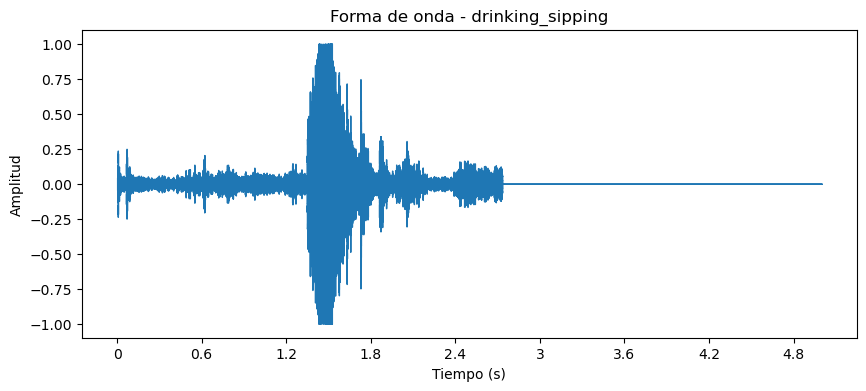

In [8]:
# Seleccionar un archivo de audio aleatorio del dataset
example_row = metadata.sample(1).iloc[0]
file_path = os.path.join(audio_path, example_row['filename'])

# Cargar el audio
y, sr = librosa.load(file_path, sr = None)

# Reproducir el audio
print(f"Reproduciendo: {example_row['filename']} (Clase: {example_row['category']})")
ipd.display(ipd.Audio(y, rate = sr))

# Visualizar la forma de onda
plt.figure(figsize = (10, 4))
librosa.display.waveshow(y, sr = sr)
plt.title(f"Forma de onda - {example_row['category']}")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.show()


In [9]:
for index, row in metadata.iterrows():
    file_path = os.path.join(audio_path, row['filename'])
    if not os.path.exists(file_path):
        print(f"Archivo faltante: {file_path}")


In [10]:
# 2. Preprocesar audios y aplicar Transformada Wavelet
class ESC50Dataset(Dataset):
    def __init__(self, metadata, transform = None):
        self.metadata = metadata
        self.transform = transform
        
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        file_path = os.path.join(audio_path, row['filename'])
        label = row['target']
        
        # Cargar audio
        y, sr = librosa.load(file_path, sr=None)
        
        # Aplicar Transformada de Ondícula Continua (CWT) con la ondícula de Morlet
        scales = np.arange(1, 128)
        coefficients, _ = pywt.cwt(y, scales, 'cmor1.5-1.0')
        image = np.abs(coefficients)
        
        # Convertir a imagen
        image = Image.fromarray((image / np.max(image) * 255).astype(np.uint8))
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [11]:
# 3. Definir transformaciones para normalizar imágenes
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.expand(3, -1, -1))  # Convierte 1 canal a 3 canales
])


In [12]:
dataset = ESC50Dataset(metadata.iloc[:10], transform = transform)

print("Ejemplo de datos cargados:", dataset[0])



Ejemplo de datos cargados: (tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 0)


In [13]:
train_data, test_data = train_test_split(dataset, test_size = 0.2, random_state = 42)
train_loader = DataLoader(train_data, batch_size = 32, shuffle = True, num_workers = 4)
test_loader = DataLoader(test_data, batch_size = 32, shuffle = False, num_workers = 4)


In [14]:
# 4. Definir la Red Neuronal Convolucional (CNN)
class AudioCNN(nn.Module):
    def __init__(self, num_classes = 50):
        super(AudioCNN, self).__init__()
        self.model = models.resnet18(pretrained = True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)


In [15]:
# 5. Entrenar el modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AudioCNN(num_classes = 50).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

def train_model(model, train_loader, criterion, optimizer, num_epochs = 10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

train_model(model, train_loader, criterion, optimizer)


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 4.9034
Epoch 2, Loss: 0.8793
Epoch 3, Loss: 0.0322
Epoch 4, Loss: 0.0049
Epoch 5, Loss: 0.0020
Epoch 6, Loss: 0.0011
Epoch 7, Loss: 0.0006
Epoch 8, Loss: 0.0004
Epoch 9, Loss: 0.0003
Epoch 10, Loss: 0.0002


In [ ]:
# 6. Guardar el modelo entrenado
torch.save(model.state_dict(), "audio_classification_model.pth")
print("Modelo guardado con éxito.")
